# Chapter 3: Calibration of the HBV model

In this chapter the HBV model is calibrated using the observation data. A set of parameters is used by the HBV model to predict the discharge. These parameters are optimized using calibration. The model requires forcings, rainfall and potential evaporation, as inputs. With the calibrated parameters, it can calculate modelled discharge at the outlet of the catchment. 

The HBV model  is available through eWaterCycle. The developer of the model, Sten Bergström (1992), says the HBV model can best be classified as a semi-distributed conceptual model. The model consists of three main components:
- subroutines for snow accumulation and melt
- subroutines for soil moisture accounting
- response and river routing subroutines

Precipitation and air temperature are the model inputs, and data on potential evapotranspiration is needed for the accounting of soil moisture. (Bergström, 1992)

A visual representation of the HBV model can be seen below:

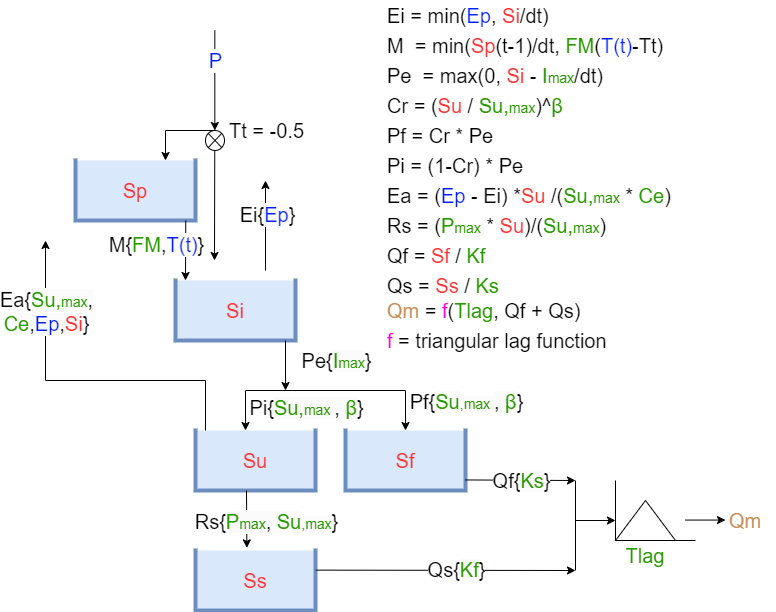

*Image from the TU Delft course ENVM1502 - "River Basin Hydrology" by Markus Hrachowitz* 

## General

First of all, some general python and eWaterCycle libraries need to be imported:

In [1]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

#niceties
from rich import print
import seaborn as sns
sns.set()

#needed
from ipywidgets import IntProgress
from IPython.display import display

# general eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

As stated in chapter 3, eWaterCycle provides access to the Caravan dataset, from which a Camel dataset of the catchment of the Wien River is loaded.

In [2]:
camelsgb_id = "lamah_208082"

  The start and end date of the experiment have to be specified. The start and end date of the calibration have to be specified as well. The period of calibration is chosen to be around 75% of the experiment period. This means that the model is trained on 75% of the observation data, and can be tested on 25% of the observation data, to make sure the model is not only working for the data it was trained on, but on other periods of data as well. 

In [3]:
# calibration dates op 75% van de experiment dates zetten!!!

experiment_start_date = "1981-08-01T00:00:00Z"
experiment_end_date = "2020-12-31T00:00:00Z"

calibration_start_time = experiment_start_date
calibration_end_time = "2010-08-31T00:00:00Z"

validation_start_time = "2010-08-31T00:00:00Z"
validation_end_time = experiment_end_date

The forcing data can be generated or previously generated data can be loaded.

In [4]:
# Even though we don't use caravan data as forcing, we still call it forcing
# because it is generated using the forcing module of eWaterCycle
forcing_path_caravan = Path.home() / "forcing" / camelsgb_id / "caravan"
forcing_path_caravan.mkdir(exist_ok=True, parents=True)

# If someone has prepared forcing for you, this path needs to be changed to that location. 
prepared_forcing_path_caravan_central = Path("location/of/forcing/data")

In [5]:
# # option one: generate forcing data
# camelsgb_forcing = ewatercycle.forcing.sources['CaravanForcing'].generate(
#     start_time=experiment_start_date,
#     end_time=experiment_end_date,
#     directory=forcing_path_caravan,
#     basin_id=camelsgb_id,
# )


# option two or three: load data that you or someone else generated previously
camelsgb_forcing = ewatercycle.forcing.sources['CaravanForcing'].load(Path("/home/thirza/forcing/lamah_208082/caravan"))

print(camelsgb_forcing)

CaravanForcing(
    start_time='1981-08-01T00:00:00Z',
    end_time='2030-12-31T00:00:00Z',
    directory=PosixPath('/home/thirza/forcing/lamah_208082/caravan'),
    shape=PosixPath('/home/thirza/forcing/lamah_208082/caravan/lamah_208082.shp'),
    filenames={
        'tasmax': 'lamah_208082_1981-08-01_2030-12-31_tasmax.nc',
        'tas': 'lamah_208082_1981-08-01_2030-12-31_tas.nc',
        'tasmin': 'lamah_208082_1981-08-01_2030-12-31_tasmin.nc',
        'Q': 'lamah_208082_1981-08-01_2030-12-31_Q.nc',
        'pr': 'lamah_208082_1981-08-01_2030-12-31_pr.nc',
        'evspsblpot': 'lamah_208082_1981-08-01_2030-12-31_evspsblpot.nc'
    }
)

Above, it can be seen that the forcing data contains precipitation, potential evaporation, discharge and the near-surface temperatures (tas). For this research, only the discharge data is relevant. The discharge data is loaded from the forcing below, and is plotted.

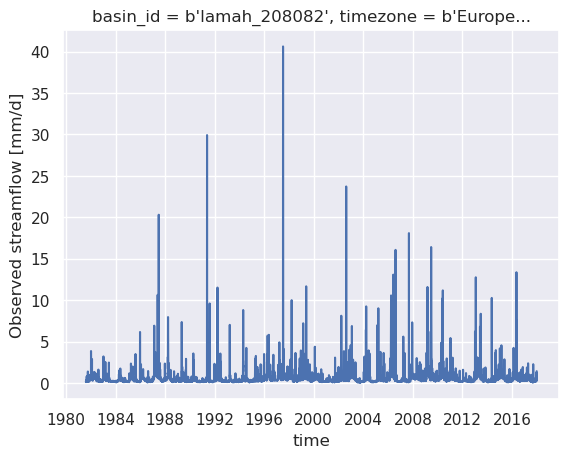

In [6]:
#quick plot of the discharge data.
ds_forcing = xr.open_mfdataset([camelsgb_forcing['Q']])
ds_forcing["Q"].plot()

## Calibration

The HBV model contains five stores where the water is stored and nine parameters that control the flow between those stores and in and out of the model. For the storages an array of starting values is specified. The values for the parameters will later be estimated using optimization.

In [7]:

#               Si,  Su, Sf, Ss, Sp
s_0 = np.array([0,  100,  0,  5, 0])
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Slowflow storage", "Groundwater storage"]

p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$", "FM"]
param_names = ["Imax","Ce",  "Sumax", "beta",  "Pmax",  "Tlag",   "Kf",   "Ks", "FM"]\

# p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001,  .01])
# p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01,  0.5])

# p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   0.1,  .01,  .0001,  .01])
# p_max_initial = np.array([8,    4,  800,   4,    3,     10,    3,   .1,  5])


### Kling Gupta efficiency

For my research, the height and frequency of the peaks are important, but their timing is less critical. The Kling-Gupta Efficiency is a measure that evaluates how well a model performs by looking at correlation, bias, and variability. By using an altered Kling-Gupta Efficiency in which the correlation is being left out, the timing of the peaks is not being taken into account. This method is useful for predicting the size of peaks and the overall distribution, while being less focused on the exact timing of the peaks.

A good way to predict the best parameter combination is through Nelder-Mead optimization. This optimization method finds the minimum of a function. The result of the Nelder-Mead optimization is the best parameter combination the method found. The Nelder-Mead optimization is run using the Kling-Gupta efficiency.

In [8]:
import numpy as np
Q_pandas = ds_forcing["Q"].to_dataframe()
def kling_gupta_efficiency(obs, sim, start_calibration, end_calibration):

    #combine the two in one dataFrame
    hydro_data = pd.concat([sim.reindex(obs.index, method = 'ffill'), obs], axis=1)

    #only select the calibration period
    hydro_data = hydro_data[hydro_data.index > pd.to_datetime(pd.Timestamp(start_calibration).date())]
    hydro_data = hydro_data[hydro_data.index < pd.to_datetime(pd.Timestamp(end_calibration).date())]


    #  #calculate mean absolute difference to the power 4, so peaks weigh more
    # diff = (hydro_data['Q'] - hydro_data['model output']) 
    # absDiff = np.abs(diff)
    # meanAbsDiff = np.mean(absDiff)
    
    r = np.corrcoef(hydro_data['Q'], hydro_data['model output'])[0, 1]  # Correlation
    beta = np.mean(hydro_data['model output']) / np.mean(hydro_data['Q'])  # Bias ratio
    gamma = np.std(hydro_data['model output']) / np.std(hydro_data['Q'])  # Variability ratio

    mean_pieken_output = hydro_data[hydro_data['model output'] > hydro_data['model output'].quantile(0.95)]["model output"].mean()
    mean_pieken_obs = hydro_data[hydro_data['Q'] > hydro_data['Q'].quantile(0.95)]["Q"].mean()
    ratio_pieken = mean_pieken_output / mean_pieken_obs


    #aangepaste kling-gupta zonder correlatie: geen tijds afhankelijke component
    return -(1 - np.sqrt((beta - 1) ** 2 + (gamma - 1) ** 2))
    
    # return -(1 - np.sqrt((r - 1) ** 2 + (beta - 1) ** 2 + (gamma - 1) ** 2 + (ratio_pieken - 1)**2))

# objective = kling_gupta_efficiency(observations, model_output)


In [9]:
def objective_function(parameter_vector):
    model = ewatercycle.models.HBVLocal(forcing=camelsgb_forcing)
    config_file, _ = model.setup(            parameters = parameter_vector,
                            initial_storage=s_0,
                            cfg_dir = "configFiles/hbv_ensembleMember_",
                               )
    model.initialize(config_file)


   # discharge_this_timestep = model.get_value("Q") 
    Q_m = []
    time = []
    while model.time < model.end_time:
        model.update()
        discharge_this_timestep = model.get_value("Q")
        Q_m.append(discharge_this_timestep[0])
        time.append(pd.Timestamp(model.time_as_datetime.date()))
   # model.finalize()
   # print(model.get_value("Q"))

    #calculate the objective function 
    discharge_dataframe = pd.DataFrame({'model output': Q_m}, index=pd.to_datetime(time))

    objective_this_model = kling_gupta_efficiency(discharge_dataframe, Q_pandas["Q"], calibration_start_time, calibration_end_time)
    del Q_m, time, discharge_dataframe
   
    if np.isnan(objective_this_model):
        return np.inf
    
    return objective_this_model

In [10]:
# from scipy.optimize import minimize


# #bounds = [(0, 500), (0.2, 10),(40, 10000),(0.5, 10000),(0.001, 300),(1, 100),(0.01, 100),(0.0001, 10),(0.01, 100)]
# bounds = [(0, None), (0.001, None),(0.001, None),(0.001, None),(0.001, None),(0.001, None),(0.001, None),(0.001, None),(0.001, None)]

# result90 = minimize(objective_function, [2.52268517e-05, 2.20175052e+00, 1.45074493e+02, 2.48038674e+00,
#        1.01841470e+00, 6.84361550e-01, 5.85949449e-01, 4.42305303e-02,
#        1.05644244e+00], bounds=bounds, method='Nelder-Mead', options={'maxiter':3000})

In [11]:
# result90

In [12]:
# result90.x
# result90 = [7.34828691e-05, 2.27980671e+00, 3.97078692e+02, 4.84468361e+00,
#        6.23856365e-03, 8.49211209e-01, 5.44326491e-01, 8.85417304e-03,
#        1.00205456e+00]

# no correlation:
result90 = [3.45931194e-05, 1.14214815e+00, 8.18372400e+01, 3.33622498e+00,
       7.92467684e-01, 7.14312426e-01, 6.98977188e-01, 4.48466788e-02,
       1.08758732e+00]

In [13]:
# result90.fun
# objective = -0.5152300312227525
# no correlation:
# objective = -0.9999994796207085

In [14]:
par = result90
model = ewatercycle.models.HBVLocal(forcing=camelsgb_forcing)
config_file, _ = model.setup(parameters=par, initial_storage=s_0)
model.initialize(config_file)

In [15]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q")[0])
    time.append(pd.Timestamp(model.time_as_datetime))
model.finalize()

In [16]:
model_output = pd.Series(data=Q_m, name="Modelled_discharge", index=time)

Text(0, 0.5, 'Discharge (mm/d)')

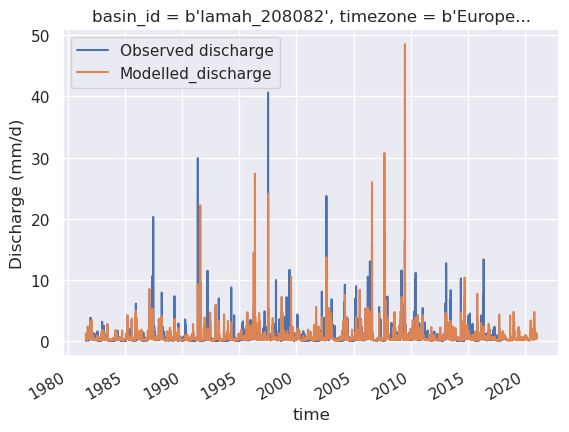

In [17]:
ds_forcing["Q"].plot(label="Observed discharge")
model_output.plot()
plt.legend()
plt.ylabel("Discharge (mm/d)")

To be able to compare the model output to the observation data, the model output is converted from mm/day to m3/s as well. This is plotted below.

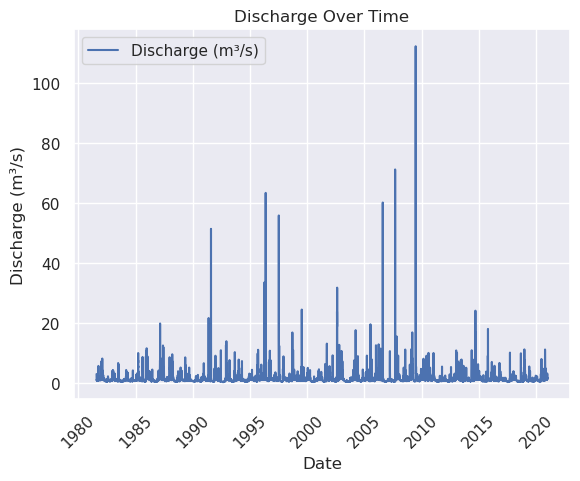

In [18]:
catchment_area = ds_forcing["area"].values

df = pd.DataFrame(model_output)
model_data = df['Modelled_discharge'] * catchment_area * 1000 / (24 * 60 * 60)

plt.plot(df.index, model_data, label='Discharge (m³/s)')

plt.xlabel('Date')
plt.ylabel('Discharge (m³/s)')
plt.title('Discharge Over Time')
plt.xticks(rotation=45)  # Draai de datums voor betere leesbaarheid
plt.legend()
plt.show()

To be able to evaluate the performence of the model, the extrapolated returnperiods for the modeloutput need to be compared to the extrapolated returnperiods for the observations. The modelled daily discharges are plotted below. The returnperiods still have to be extrapolated.

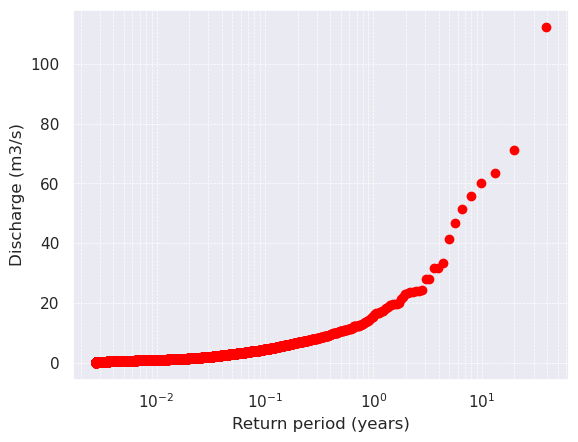

In [19]:
 # Sort data from high to low
sorted_model_data = np.sort(model_data)[::-1]  # Sorteer aflopend

#calculate return periods
m = len(sorted_model_data)
rank = np.arange(1, m + 1)
return_periods_days_model = (m + 1) / rank
return_periods_years_model = return_periods_days_model / 365

plt.xscale('log')
plt.scatter(return_periods_years_model, sorted_model_data, color="red", label="Waarden")
plt.xlabel('Return period (years)')
plt.ylabel('Discharge (m3/s)')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)